<a href="https://colab.research.google.com/github/WilliamJWen/APS360/blob/main/lab/Lab2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/github/WilliamJWen/APS360/blob/main/lab/Lab2_Cats_vs_Dogs.ipynb

In [21]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [22]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [23]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:02<00:00, 58.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [24]:
print(classes)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

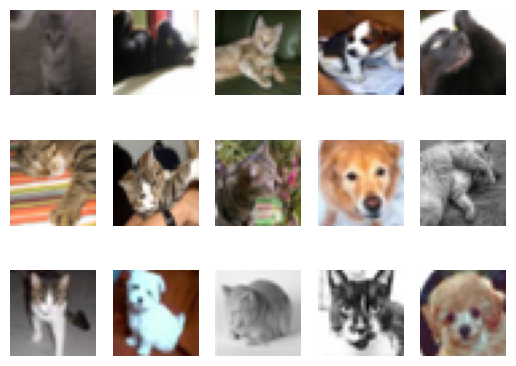

In [25]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [26]:
def get_class_num(data_loader, target_classes, classes, batch_size=1):
  sum = 0
  for _, labels in data_loader:
    for i in range(batch_size):
      if classes[labels[i]] in target_classes:
        sum += 1
  return sum


In [27]:
num_training = get_class_num(train_loader, ['cat', 'dog'], classes)
print(f"Training data has {num_training} examples.")

Training data has 8000 examples.


In [28]:
num_validation = get_class_num(val_loader, ['cat', 'dog'], classes)
print(f"Validation data has {num_validation} examples.")

Validation data has 2000 examples.


In [29]:
num_test = get_class_num(test_loader, ['cat', 'dog'], classes)
print(f"Test data has {num_test} examples.")

Test data has 2000 examples.


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

Because the model might overfit on the training data and not generalize well with unseen data.  If we judge the performance of our model using the training set, the model might not work well outside training data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [30]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [31]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [32]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [33]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


1. input_channel=3, output_channel=5, kernel_size=3: 5 * 3 * (3*3) = 135
2. each kernel has one bias: 5 bias in total
3. linear layer weights: 5 * 7 * 7 = 245
4. linear layer bias: 1

Small Net Total: 135 + 5 + 245 + 1 = 386

In [34]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


1. First convolution layer weights: 5 * 3 * (3 * 3) = 135
2. First convolution layer biases: 5
3. Second convolution layer weights: 10 * 5 * (5 * 5) = 1250
4. Second convolution layer biases = 10
5. First Linear layer: (10*5*5 + 1) * 32 = 8032
6. Second Linear Layer: 32 + 1 = 33

Large Net Total: 135 + 5 + 1250 + 10 + 8032 + 33 = 9465

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [35]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
train_net(small_net, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.407, Train loss: 0.667199803352356 |Validation err: 0.3645, Validation loss: 0.6535256784409285
Epoch 2: Train err: 0.362375, Train loss: 0.6420805797576904 |Validation err: 0.3625, Validation loss: 0.6560147926211357
Epoch 3: Train err: 0.344, Train loss: 0.6250305171012879 |Validation err: 0.346, Validation loss: 0.6192000135779381
Epoch 4: Train err: 0.3275, Train loss: 0.6064884612560272 |Validation err: 0.358, Validation loss: 0.6206242982298136
Epoch 5: Train err: 0.313, Train loss: 0.5945103867053986 |Validation err: 0.3335, Validation loss: 0.6171601004898548
Finished Training
Total time elapsed: 24.98 seconds


### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

```
batch_size=64, learning_rate=0.01, num_epochs=30
```



### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

1. model_small_bs64_lr0.01_epoch0
2. model_small_bs64_lr0.01_epoch1
3. model_small_bs64_lr0.01_epoch2
4. model_small_bs64_lr0.01_epoch3
5. model_small_bs64_lr0.01_epoch4: The first 5 (num_epochs) include training checkpoint
6. model_small_bs64_lr0/01_epoch4_train_err.csv: This file includes training error for all epochs
7. model_small_bs64_lr0.01_epoch4_train_loss.csv: This file includes training loss for all epochs
8. model_small_bs64_lr0.01_epoch4_val_err.csv: This file includes validation error for all epochs
9. model_small_bs64_lr0.01_epoch4_val_loss.csv: This file includes validation loss for all epochs



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [1]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
%cd /content/gdrive/My\ Drive/APS360/lab2

/content/gdrive/My Drive/APS360/lab2


In [36]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.421625, Train loss: 0.6731509938240051 |Validation err: 0.374, Validation loss: 0.6557718086987734
Epoch 2: Train err: 0.374375, Train loss: 0.6496485209465027 |Validation err: 0.39, Validation loss: 0.6651532631367445
Epoch 3: Train err: 0.361, Train loss: 0.639861445903778 |Validation err: 0.3525, Validation loss: 0.6295056864619255
Epoch 4: Train err: 0.348875, Train loss: 0.6259571614265442 |Validation err: 0.366, Validation loss: 0.6303201373666525
Epoch 5: Train err: 0.34075, Train loss: 0.6158594551086426 |Validation err: 0.3435, Validation loss: 0.6180127058178186
Epoch 6: Train err: 0.3255, Train loss: 0.6037004952430725 |Validation err: 0.344, Validation loss: 0.6141274329274893
Epoch 7: Train err: 0.312875, Train loss: 0.5957530188560486 |Validation err: 0.333, Validation loss: 0.6037453357130289
Epoch 8: Train err: 0.306625, Train loss: 0.5844123985767364 |Validation err: 0.328

In [37]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.453, Train loss: 0.6904229679107666 |Validation err: 0.4275, Validation loss: 0.6822816506028175
Epoch 2: Train err: 0.414875, Train loss: 0.6760451622009277 |Validation err: 0.415, Validation loss: 0.6743557471781969
Epoch 3: Train err: 0.388, Train loss: 0.658094557762146 |Validation err: 0.3635, Validation loss: 0.6384367719292641
Epoch 4: Train err: 0.36725, Train loss: 0.6404334626197815 |Validation err: 0.3925, Validation loss: 0.6626926809549332
Epoch 5: Train err: 0.353125, Train loss: 0.6281444444656372 |Validation err: 0.334, Validation loss: 0.6213582698255777
Epoch 6: Train err: 0.345, Train loss: 0.6143880038261413 |Validation err: 0.3395, Validation loss: 0.6160747595131397
Epoch 7: Train err: 0.329125, Train loss: 0.6034681572914123 |Validation err: 0.331, Validation loss: 0.6057911794632673
Epoch 8: Train err: 0.31375, Train loss: 0.5849707055091858 |Validation err: 0.335, 

It took **138.70 seconds** to train the **small_net**, and **158.24 seconds** for **large_net**. Network large_net took longer to train, because it has more parameters to performe gradient descent and train.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

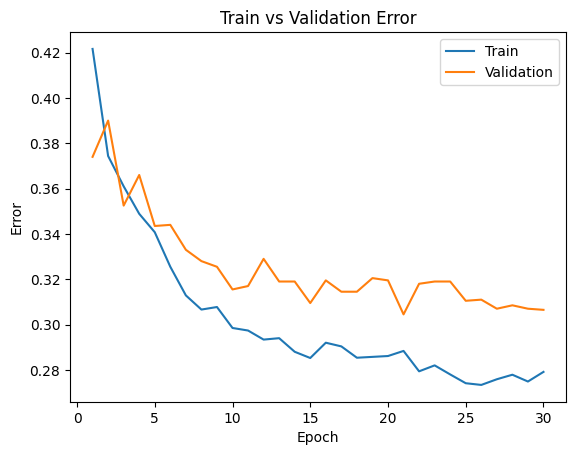

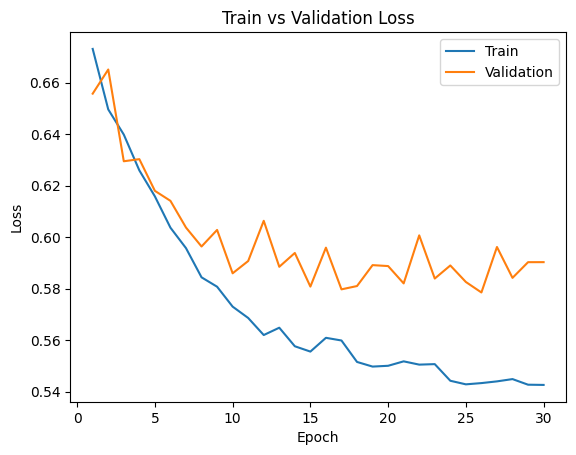

In [40]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

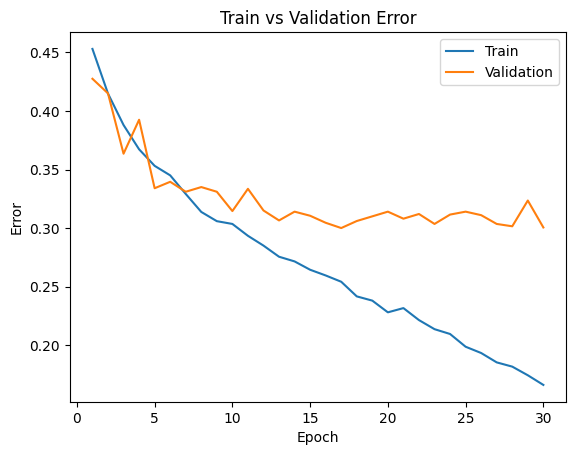

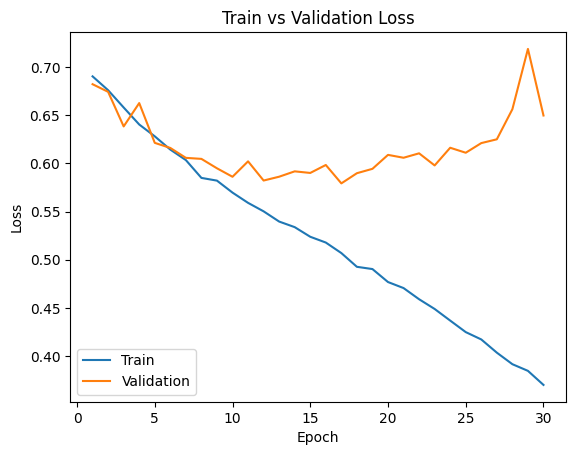

In [41]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

### Similarities
1. Both models perform better on training data than validation.
2. Both models have improved (smaller) error and loss with more epochs.

### Difference:
1. small_net performs slightly worse on validation data compared to training data near the end of training, while large_net perform really bad on the validation data.
2. At the last epoch, large_net performs much better on training data.

### Underfitting
1. Both networks shows underfitting at the beginning epochs, and towards the end, small_net still has a 0.28 error

### Overfitting
1. After epoch 15, large_net starts to has an increase loss on validation data, it is overfitting on the training data.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [43]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6945205245018006 |Validation err: 0.491, Validation loss: 0.6929903626441956
Epoch 2: Train err: 0.50225, Train loss: 0.6930276026725769 |Validation err: 0.491, Validation loss: 0.6924116909503937
Epoch 3: Train err: 0.487375, Train loss: 0.6922532548904419 |Validation err: 0.4765, Validation loss: 0.6920256353914738
Epoch 4: Train err: 0.448375, Train loss: 0.6916862654685975 |Validation err: 0.4515, Validation loss: 0.6913806144148111
Epoch 5: Train err: 0.44225, Train loss: 0.6910704188346862 |Validation err: 0.4415, Validation loss: 0.6910937838256359
Epoch 6: Train err: 0.44025, Train loss: 0.6903750495910644 |Validation err: 0.4375, Validation loss: 0.6905073542147875
Epoch 7: Train err: 0.438, Train loss: 0.6895525403022766 |Validation err: 0.4345, Validation loss: 0.6896938290446997
Epoch 8: Train err: 0.439, Train loss: 0.6884716792106629 |Validation err: 0.43

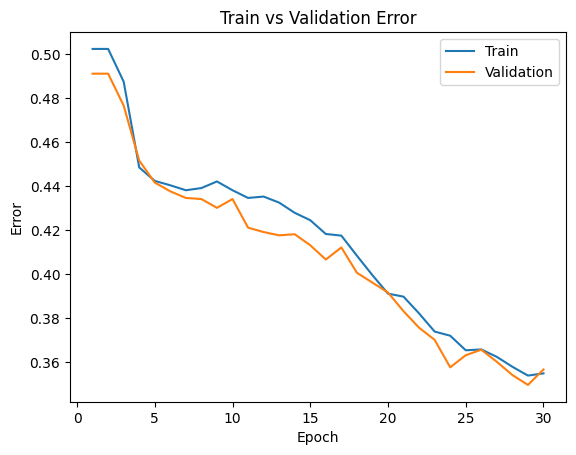

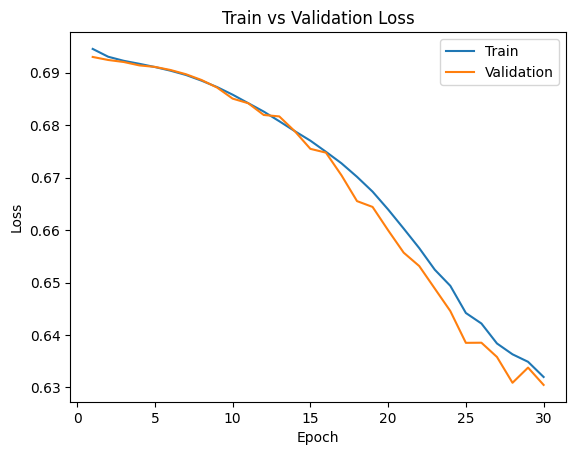

In [44]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

- It took 150.50 seconds to train larger_net with learning rate 0.001, which is **a little shorter** than 158.24 seconds for large_net with default hyperparameters.
- Note: Because the model is only trained for 30 epochs, so changing the learning rate didn't have a huge impact on time in this case, but we would expect longer training time and more epochs needed for a smaller learning rate, because it updates the weights more gently.

- Lowering the learning rate significantly improve the network's performance on validation data. The network now performs similar on training data and validation data.
- But lowering the learning rate without increasing number of epochs causes the model has a relatively larger error and loss on training data compared to before.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [45]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743808445930481 |Validation err: 0.3565, Validation loss: 0.6350402887910604
Epoch 2: Train err: 0.36925, Train loss: 0.6415545463562011 |Validation err: 0.3515, Validation loss: 0.6243696268647909
Epoch 3: Train err: 0.366, Train loss: 0.6304733338356018 |Validation err: 0.3475, Validation loss: 0.6173483617603779
Epoch 4: Train err: 0.35775, Train loss: 0.6251179370880127 |Validation err: 0.3345, Validation loss: 0.620793430134654
Epoch 5: Train err: 0.33675, Train loss: 0.6045795600414277 |Validation err: 0.329, Validation loss: 0.5937281344085932
Epoch 6: Train err: 0.31775, Train loss: 0.5828781847953797 |Validation err: 0.3275, Validation loss: 0.6041664052754641
Epoch 7: Train err: 0.3195, Train loss: 0.5794640259742737 |Validation err: 0.334, Validation loss: 0.6052154619246721
Epoch 8: Train err: 0.311875, Train loss: 0.5757701637744903 |Validation err: 0.318,

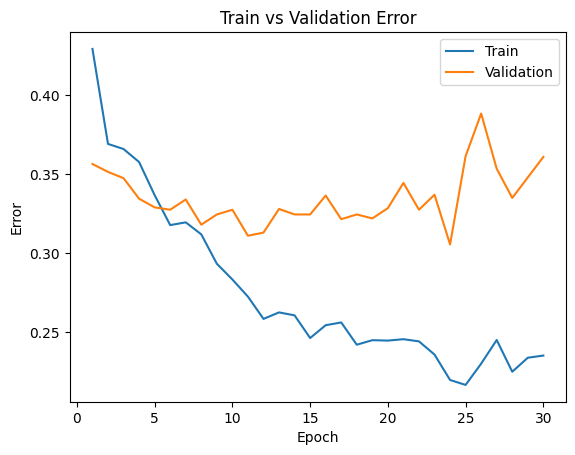

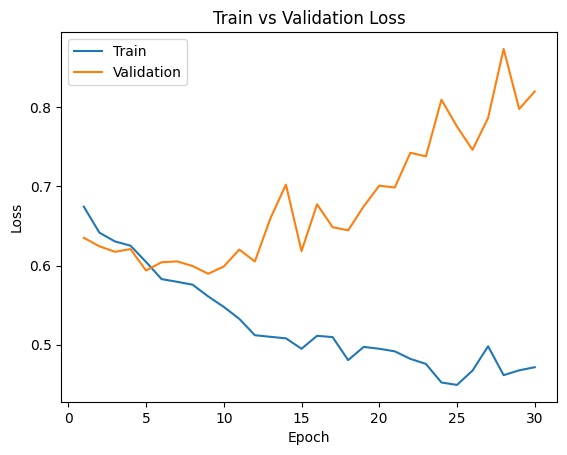

In [46]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

- It took 159.99 seconds to train larger_net with learning rate 0.1, which is **a little longer** than 158.24 seconds for large_net with default hyperparameters.

- Increasing the learning rate made the network's performance on validation data worse. The model reach its lowest point for validation and starts to overfit at an early stage of around epoch 5 because the weights are updated too aggresively.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [47]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.01, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.692410409450531 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770620465279 |Validation err: 0.411, Val

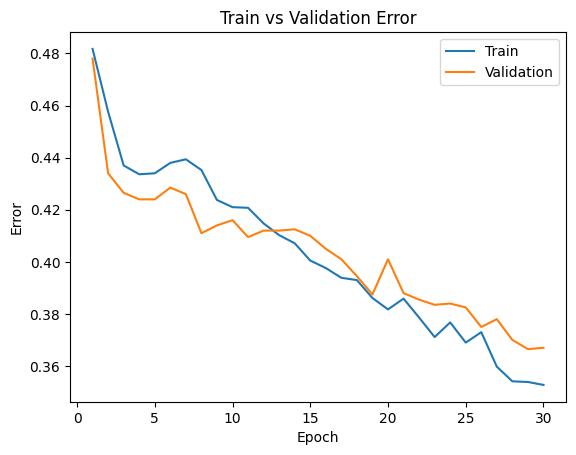

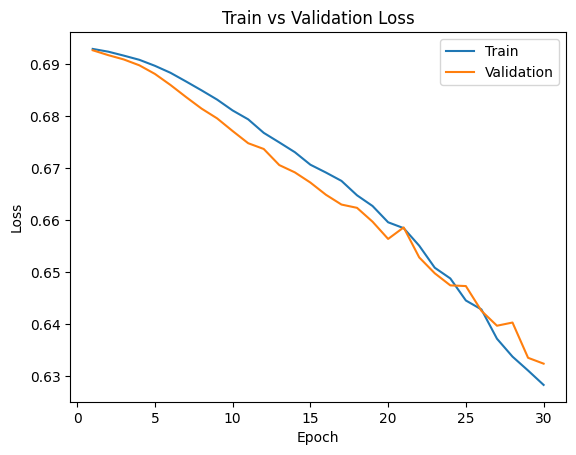

In [48]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

- The model takes 143.94 seconds to train, which is **shorter** than 158.24 for model with default parameters. Because more samples are merged into one batch, the model now update the parameters fewer times for each iteration.
- Increasing the batch size resolved overfitting issue, the model now peforms similiar on training data and validation dat, but after 30 epochs, the model has a larger error and loss compared to before.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [49]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.01, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775506126880646 |Validation err: 0.378, Validation loss: 0.6512571973800659
Epoch 2: Train err: 0.366375, Train loss: 0.6387728816270828 |Validation err: 0.337, Validation loss: 0.612742235660553
Epoch 3: Train err: 0.339375, Train loss: 0.6119522891640663 |Validation err: 0.345, Validation loss: 0.6396356213092804
Epoch 4: Train err: 0.312125, Train loss: 0.5861616842746734 |Validation err: 0.3375, Validation loss: 0.6223122742176056
Epoch 5: Train err: 0.309125, Train loss: 0.5655454085469246 |Validation err: 0.303, Validation loss: 0.5682719912528992
Epoch 6: Train err: 0.283875, Train loss: 0.546434996843338 |Validation err: 0.3125, Validation loss: 0.581913836479187
Epoch 7: Train err: 0.275625, Train loss: 0.5315411986708641 |Validation err: 0.3185, Validation loss: 0.5755203785896301
Epoch 8: Train err: 0.253625, Train loss: 0.5110043309926987 |Validation err:

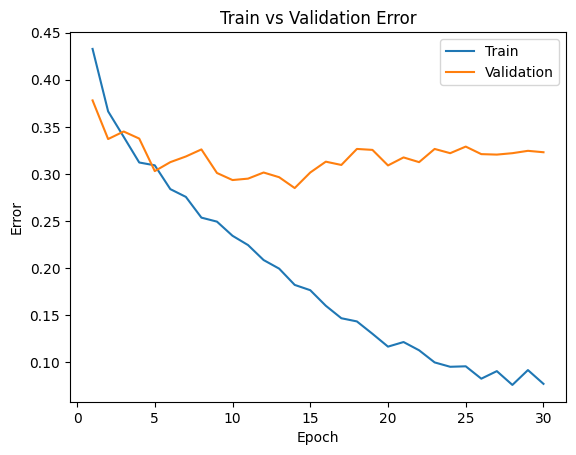

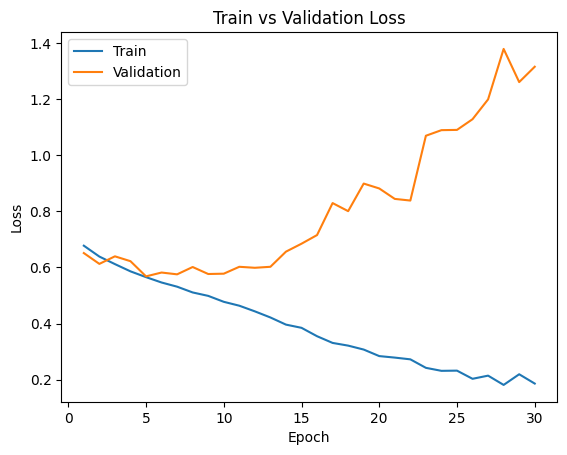

In [50]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

- The model with decreased batch size used 214.19 seconds to train which is longer, due to more smaller batch size and larger batch numbers, and more updates on weights for each iteration.
- The error and loss on validation data and training data is about the same as the default one due to small batch size.
- Overfitting appeared at an early stage, and the model performs poorly on validation data.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [53]:
network=large_net; batch_size=256; learning_rate=0.005

- Larger Network with 2 filter level can capture more complex higer level feature
- A large batch_size of 512 has proven to be able to resolve the overfitting issue, but had a relative larger error and loss, so choose 256 to mitigate
- A smaller learning_rat at 0.001 performed well, but 30 epochs were not enough for it to reach an optmial low error and loss, so slightly increase learning rate to 0.005

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [54]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.005, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.477625, Train loss: 0.6928693596273661 |Validation err: 0.4685, Validation loss: 0.6925142854452133
Epoch 2: Train err: 0.451125, Train loss: 0.6922451816499233 |Validation err: 0.436, Validation loss: 0.6914755180478096
Epoch 3: Train err: 0.43525, Train loss: 0.6914684548974037 |Validation err: 0.4265, Validation loss: 0.690574586391449
Epoch 4: Train err: 0.42875, Train loss: 0.6903846431523561 |Validation err: 0.419, Validation loss: 0.6891278326511383
Epoch 5: Train err: 0.43725, Train loss: 0.6891164481639862 |Validation err: 0.4255, Validation loss: 0.6870567947626114
Epoch 6: Train err: 0.435125, Train loss: 0.6875725593417883 |Validation err: 0.423, Validation loss: 0.6847672164440155
Epoch 7: Train err: 0.4355, Train loss: 0.6857214942574501 |Validation err: 0.4175, Validation loss: 0.6822823286056519
Epoch 8: Train err: 0.431625, Train loss: 0.684075903147459 |Validation err: 0.

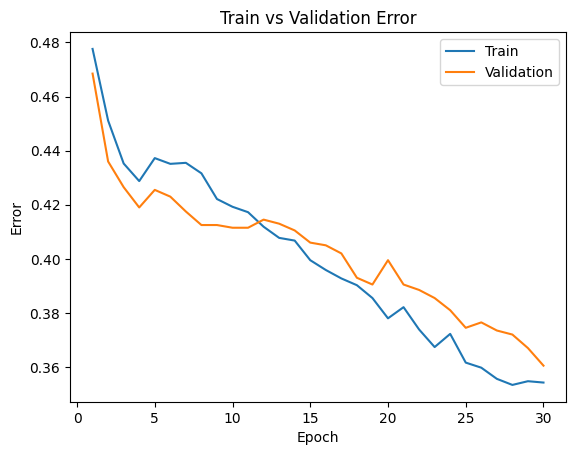

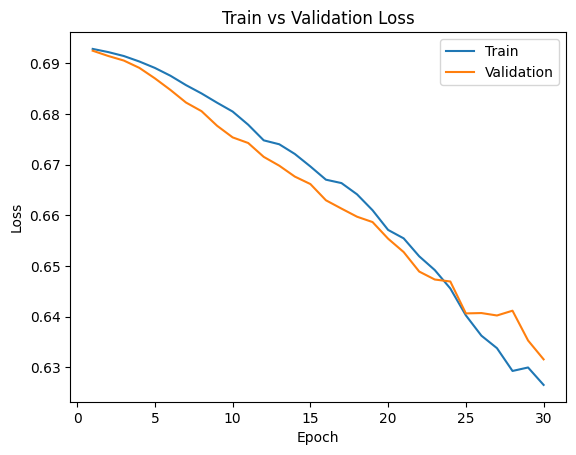

In [57]:
model_path = get_model_name("large", batch_size=256, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [56]:
network=large_net; batch_size=128; learning_rate=0.007

Try to increase learning_rate by a little bit and decrease batch_size by a little to see if the model could converge faster to the optimal.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [59]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.007, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.456625, Train loss: 0.6923577293517098 |Validation err: 0.4225, Validation loss: 0.6909653209149837
Epoch 2: Train err: 0.449875, Train loss: 0.68995991301915 |Validation err: 0.422, Validation loss: 0.686371460556984
Epoch 3: Train err: 0.43025, Train loss: 0.68569225640524 |Validation err: 0.412, Validation loss: 0.6801501959562302
Epoch 4: Train err: 0.424375, Train loss: 0.6803465040903243 |Validation err: 0.411, Validation loss: 0.6731189228594303
Epoch 5: Train err: 0.414125, Train loss: 0.6752495491315448 |Validation err: 0.4105, Validation loss: 0.6691057458519936
Epoch 6: Train err: 0.402, Train loss: 0.6695586755162194 |Validation err: 0.396, Validation loss: 0.6658896021544933
Epoch 7: Train err: 0.391625, Train loss: 0.6636022792922126 |Validation err: 0.393, Validation loss: 0.6578965857625008
Epoch 8: Train err: 0.38575, Train loss: 0.6574216920232016 |Validation err: 0.3865,

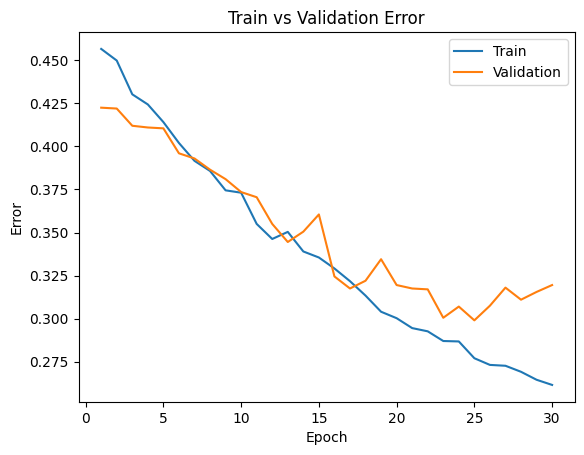

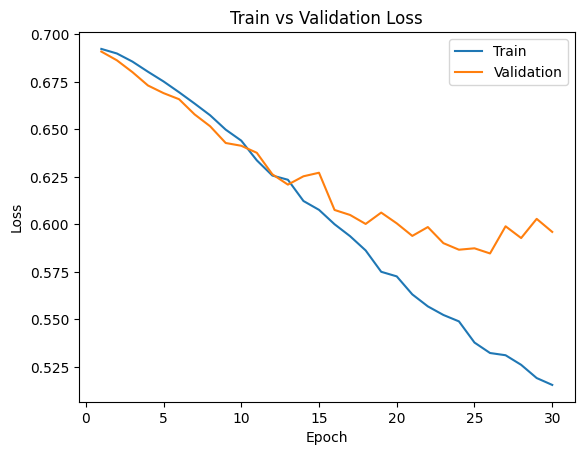

In [60]:
model_path = get_model_name("large", batch_size=128, learning_rate=0.007, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [62]:
net = large_net
model_path = get_model_name('large', batch_size=128,
                            learning_rate=0.007, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<ipython-input-62-2e2dd8c79b0a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

### **Network:**  
**Large_net** – With two filters, it captures higher-level features that better distinguish between cats and dogs compared to **small_net**.  

### **Hyperparameters:**  
- **Batch size:** 128  
- **Learning rate:** 0.007  
- **Epochs:** 29  

This combination achieved the **best validation error (0.309) and loss (0.588)** among all tested hyperparameter sets. Although the validation error is slightly higher than the default parameters, the significantly lower validation loss suggests improved model performance.

In [64]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)

Files already downloaded and verified
Files already downloaded and verified


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

Comparing the validation error (0.309) with the test classification error (0.3135), we see that the test error is slightly higher. This is expected because the model has been exposed to the validation dataset multiple times during training and hyperparameter tuning, making its predictions slightly more accurate for that data. In contrast, the test dataset, which the model encounters only once, may result in a slightly higher error.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Answer:** We use the test data only at the very end to obtain an unbiased evaluation of our model's accuracy. Unlike the validation set, the test data should be exposed to the model as little as possible to ensure a realistic assessment of its performance. This helps us gauge how well the model generalizes to unseen data, reflecting its real-world effectiveness. In this case, the objective is to accurately classify cats and dogs.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.486625, Train loss: 0.6933325990553825 |Validation err: 0.455, Validation loss: 0.6879132315516472
Epoch 2: Train err: 0.427125, Train loss: 0.6793969158203371 |Validation err: 0.412, Validation loss: 0.6769351065158844
Epoch 3: Train err: 0.41125, Train loss: 0.6718620927103104 |Validation err: 0.407, Validation loss: 0.6715617030858994
Epoch 4: Train err: 0.40275, Train loss: 0.6657881871346505 |Validation err: 0.409, Validation loss: 0.6658869683742523
Epoch 5: Train err: 0.397625, Train loss: 0.662138952362922 |Validation err: 0.407, Validation loss: 0.663862407207489
Epoch 6: Train err: 0.39575, Train loss: 0.6603204511827038 |Validation err: 0.4095, Validation loss: 0.663334883749485
Epoch 7: Train err: 0.392625, Train loss: 0.6571945048147633 |Validation err: 0.4045, Validation loss: 0.6622826457023621
Epoch 8: Train err: 0.38975, Train loss: 0.6557257848401223 |Validation err: 0.40

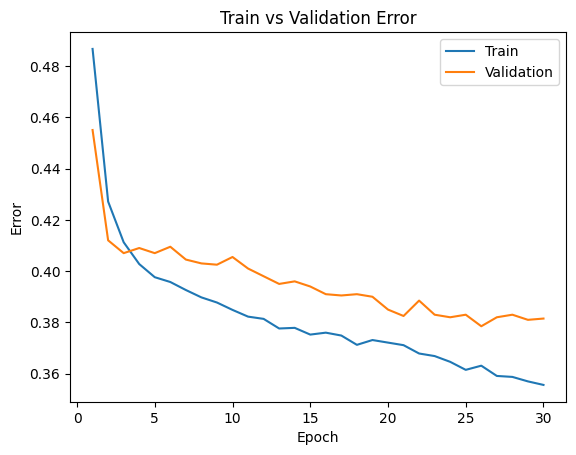

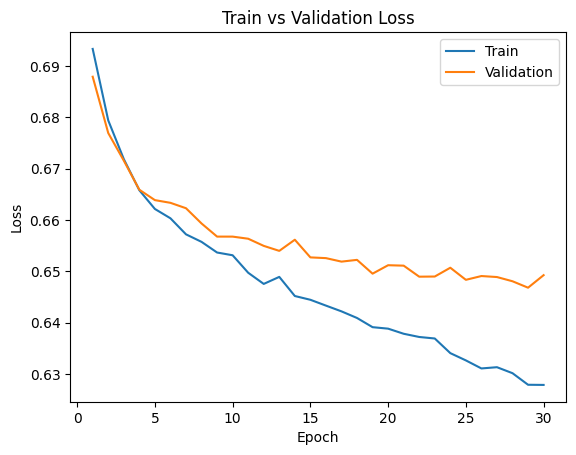

In [61]:
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
        self.name = 'ANN'
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

pigeon = Pigeon()

#Training
train_net(pigeon, batch_size = 264, learning_rate = 0.001)
pigeon_path = get_model_name("ANN", batch_size = 264, learning_rate= 0.001, epoch = 29)
plot_training_curve(pigeon_path)



In [63]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)
net = pigeon
criterion = nn.BCEWithLogitsLoss()
error, loss = evaluate(net, test_loader, criterion)
print('The test classification error is:', error)
print('The test classfication loss is:',loss)

#Compared to the CNN network, ANN has a much lower
#accuracy in classfiying cats and dogs.
#It has a test classification error of 0.37, and a
#test loss of 0.64. Therefore, using an ANN model,
#only flattening the image will lose many important
#distinguishing features for cats and dogs, whereas
# a CNN network will capture both low level and high
#level features in cats and dogs for more accurate
#classification.

Files already downloaded and verified
Files already downloaded and verified
The test classification error is: 0.3695
The test classfication loss is: 0.6419454924762249


In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab2_Cats_vs_Dogs.ipynb"